# AutoML Image Classification: Added Noise (Fashion)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/gaussian_noise.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    # random_state = RandomState(42)
    # x, y = load_digits(return_X_y=True)
    # y = y.astype(np.uint8)
    # return train_test_split(x, y, test_size=.25, random_state=random_state)
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    s = x_train.shape[1]
    x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)
    return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    # err_img_node = Array(reshape=(8, 8))
    err_img_node = Array(reshape=(28, 28))

    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(RotationPIL("max_angle"))
    # return err_root_node
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [5]:
def get_err_params_list(data):
    # angle_steps = np.linspace(0, 90, num=6)
    # err_params_list = [{"max_angle": a} for a in angle_steps]
    # return err_params_list
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [7]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*6
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import torch
        print(torch.cuda.get_device_name(0))
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=32, min_mem_size_GB=128, max_mem_size_GB=128)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        print(best_pipeline)
        h2o.remove_all()
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=params["augment"], path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": False}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": False}],
        #     "use_clean_train_data": True
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": True}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": True}],
        #     "use_clean_train_data": True
        # },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        # err_param_name="max_angle",
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    # err_params_list=get_err_params_list(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpykfouero

  JVM stdout: /wrk/users/thalvari/tmpykfouero/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpykfouero/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 8 days
H2O cluster name:,#819133210
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191216_023244', 'XGBoost_1_AutoML_20191216_023244', 'XGBoost_2_AutoML_20191216_023244', 'GBM_5_AutoML_20191216_023244', 'GBM_4_AutoML_20191216_023244', 'XGBoost_3_AutoML_20191216_023244', 'GBM_3_AutoML_20191216_023244', 'GBM_2_AutoML_20191216_023244', 'GBM_1_AutoML_20191216_023244', 'GBM_grid_1_AutoML_20191216_023244_model_1', 'DRF_1_AutoML_20191216_023244', 'XRT_1_AutoML_20191216_023244', 'XGBoost_grid_1_AutoML_20191216_023244_model_1', 'GLM_grid_1_AutoML_20191216_023244_model_1', 'XGBoost_grid_1_AutoML_20191216_023244_model_2', 'DeepLearning_1_AutoML_20191216_023244', 'DeepLearning_grid_1_AutoML_20191216_023244_model_4', 'DeepLearning_grid_1_AutoML_20191216_023244_model_2', 'DeepLearning_grid_1_AutoML_20191216_023244_model_6', 'DeepLearning_grid_1_AutoML_20191216_023244_model_5', 'GBM_grid_1_AutoML_20191216_023244_model_2', 'DeepLearning_grid_1_AutoML_20191216_023244_model_3', 'DeepLearning_grid_1_AutoML_20191216_023244_model_1', 'XGBoost_grid_1_A

H2O session _sid_9c62 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.901

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp3kvtaqxu

  JVM stdout: /wrk/users/thalvari/tmp3kvtaqxu/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp3kvtaqxu/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 8 days
H2O cluster name:,#703351722
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191216_083730', 'XGBoost_1_AutoML_20191216_083730', 'XGBoost_2_AutoML_20191216_083730', 'GBM_5_AutoML_20191216_083730', 'GBM_4_AutoML_20191216_083730', 'XGBoost_3_AutoML_20191216_083730', 'GBM_3_AutoML_20191216_083730', 'GBM_2_AutoML_20191216_083730', 'GBM_1_AutoML_20191216_083730', 'GBM_grid_1_AutoML_20191216_083730_model_1', 'DRF_1_AutoML_20191216_083730', 'XRT_1_AutoML_20191216_083730', 'XGBoost_grid_1_AutoML_20191216_083730_model_1', 'DeepLearning_1_AutoML_20191216_083730', 'GLM_grid_1_AutoML_20191216_083730_model_1', 'XGBoost_grid_1_AutoML_20191216_083730_model_2', 'DeepLearning_grid_1_AutoML_20191216_083730_model_2', 'GBM_grid_1_AutoML_20191216_083730_model_2', 'DeepLearning_grid_1_AutoML_20191216_083730_model_1', 'DeepLearning_grid_1_AutoML_20191216_083730_model_3', 'DeepLearning_grid_1_AutoML_20191216_083730_model_4', 'GBM_grid_1_AutoML_20191216_083730_model_3']

H2O session _sid_89f7 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.901

 17%|█▋        | 1/6 [12:09:34<60:47:54, 43774.99s/it]

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpbmwbc_0_

  JVM stdout: /wrk/users/thalvari/tmpbmwbc_0_/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpbmwbc_0_/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 9 days
H2O cluster name:,#1017358818
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191216_144218', 'XGBoost_2_AutoML_20191216_144218', 'XGBoost_1_AutoML_20191216_144218', 'GBM_5_AutoML_20191216_144218', 'XGBoost_3_AutoML_20191216_144218', 'GBM_3_AutoML_20191216_144218', 'GBM_1_AutoML_20191216_144218', 'GBM_2_AutoML_20191216_144218', 'GBM_4_AutoML_20191216_144218', 'GBM_grid_1_AutoML_20191216_144218_model_1', 'GLM_grid_1_AutoML_20191216_144218_model_1', 'DRF_1_AutoML_20191216_144218', 'XRT_1_AutoML_20191216_144218', 'DeepLearning_1_AutoML_20191216_144218', 'DeepLearning_grid_1_AutoML_20191216_144218_model_1', 'DeepLearning_grid_1_AutoML_20191216_144218_model_2', 'DeepLearning_grid_1_AutoML_20191216_144218_model_3', 'XGBoost_grid_1_AutoML_20191216_144218_model_1', 'GBM_grid_1_AutoML_20191216_144218_model_2', 'XGBoost_grid_1_AutoML_20191216_144218_model_2', 'GBM_grid_1_AutoML_20191216_144218_model_3']

H2O session _sid_8c1c closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.854

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp4_qtm_6x

  JVM stdout: /wrk/users/thalvari/tmp4_qtm_6x/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp4_qtm_6x/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 9 days
H2O cluster name:,#974159809
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191216_204917', 'XGBoost_1_AutoML_20191216_204917', 'XGBoost_2_AutoML_20191216_204917', 'GBM_5_AutoML_20191216_204917', 'GBM_4_AutoML_20191216_204917', 'XGBoost_3_AutoML_20191216_204917', 'GBM_3_AutoML_20191216_204917', 'GBM_2_AutoML_20191216_204917', 'GBM_1_AutoML_20191216_204917', 'DRF_1_AutoML_20191216_204917', 'XRT_1_AutoML_20191216_204917', 'GBM_grid_1_AutoML_20191216_204917_model_1', 'XGBoost_grid_1_AutoML_20191216_204917_model_1', 'DeepLearning_1_AutoML_20191216_204917', 'GLM_grid_1_AutoML_20191216_204917_model_1', 'XGBoost_grid_1_AutoML_20191216_204917_model_2', 'GBM_grid_1_AutoML_20191216_204917_model_2', 'DeepLearning_grid_1_AutoML_20191216_204917_model_1', 'DeepLearning_grid_1_AutoML_20191216_204917_model_3', 'DeepLearning_grid_1_AutoML_20191216_204917_model_2', 'GBM_grid_1_AutoML_20191216_204917_model_3']

H2O session _sid_94d2 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.64

 33%|███▎      | 2/6 [24:21:33<48:41:12, 43818.16s/it]

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpoabjm66v

  JVM stdout: /wrk/users/thalvari/tmpoabjm66v/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpoabjm66v/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 9 days
H2O cluster name:,#671784156
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_BestOfFamily_AutoML_20191217_025417', 'XGBoost_1_AutoML_20191217_025417', 'GBM_1_AutoML_20191217_025417', 'GLM_grid_1_AutoML_20191217_025417_model_1', 'DRF_1_AutoML_20191217_025417']

H2O session _sid_b80e closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.8

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1jznxdvq

  JVM stdout: /wrk/users/thalvari/tmp1jznxdvq/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1jznxdvq/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 9 days
H2O cluster name:,#88560680
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191217_085810', 'XGBoost_1_AutoML_20191217_085810', 'XGBoost_2_AutoML_20191217_085810', 'GBM_5_AutoML_20191217_085810', 'GBM_4_AutoML_20191217_085810', 'XGBoost_3_AutoML_20191217_085810', 'GBM_3_AutoML_20191217_085810', 'GBM_2_AutoML_20191217_085810', 'GBM_1_AutoML_20191217_085810', 'GBM_grid_1_AutoML_20191217_085810_model_1', 'DRF_1_AutoML_20191217_085810', 'XRT_1_AutoML_20191217_085810', 'XGBoost_grid_1_AutoML_20191217_085810_model_1', 'GLM_grid_1_AutoML_20191217_085810_model_1', 'DeepLearning_1_AutoML_20191217_085810', 'XGBoost_grid_1_AutoML_20191217_085810_model_2', 'DeepLearning_grid_1_AutoML_20191217_085810_model_2', 'GBM_grid_1_AutoML_20191217_085810_model_2', 'DeepLearning_grid_1_AutoML_20191217_085810_model_1', 'DeepLearning_grid_1_AutoML_20191217_085810_model_3', 'DeepLearning_grid_1_AutoML_20191217_085810_model_4', 'GBM_grid_1_AutoML_20191217_085810_model_3']

H2O session _sid_92b5 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.378

 50%|█████     | 3/6 [36:30:33<36:29:43, 43794.58s/it]

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp9475oyug

  JVM stdout: /wrk/users/thalvari/tmp9475oyug/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp9475oyug/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54345

Connecting to H2O server at http://127.0.0.1:54345 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 10 days
H2O cluster name:,#324559602
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191217_150317', 'XGBoost_1_AutoML_20191217_150317', 'GLM_grid_1_AutoML_20191217_150317_model_1', 'XGBoost_3_AutoML_20191217_150317', 'XGBoost_2_AutoML_20191217_150317', 'GBM_1_AutoML_20191217_150317', 'GBM_2_AutoML_20191217_150317', 'GBM_3_AutoML_20191217_150317', 'DRF_1_AutoML_20191217_150317', 'GBM_4_AutoML_20191217_150317']

H2O session _sid_91e9 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.76

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpnxg57_dv

  JVM stdout: /wrk/users/thalvari/tmpnxg57_dv/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpnxg57_dv/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 10 days
H2O cluster name:,#142416830
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191217_210702', 'XGBoost_1_AutoML_20191217_210702', 'XGBoost_2_AutoML_20191217_210702', 'GBM_5_AutoML_20191217_210702', 'GBM_4_AutoML_20191217_210702', 'XGBoost_3_AutoML_20191217_210702', 'GBM_3_AutoML_20191217_210702', 'GBM_2_AutoML_20191217_210702', 'GBM_1_AutoML_20191217_210702', 'GBM_grid_1_AutoML_20191217_210702_model_1', 'DRF_1_AutoML_20191217_210702', 'XRT_1_AutoML_20191217_210702', 'XGBoost_grid_1_AutoML_20191217_210702_model_1', 'DeepLearning_1_AutoML_20191217_210702', 'GLM_grid_1_AutoML_20191217_210702_model_1', 'XGBoost_grid_1_AutoML_20191217_210702_model_2', 'GBM_grid_1_AutoML_20191217_210702_model_2', 'DeepLearning_grid_1_AutoML_20191217_210702_model_1', 'DeepLearning_grid_1_AutoML_20191217_210702_model_2', 'DeepLearning_grid_1_AutoML_20191217_210702_model_3', 'GBM_grid_1_AutoML_20191217_210702_model_3']

H2O session _sid_ae75 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.248

 67%|██████▋   | 4/6 [48:38:31<24:18:39, 43759.72s/it]

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp20bafade

  JVM stdout: /wrk/users/thalvari/tmp20bafade/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp20bafade/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 10 days
H2O cluster name:,#693011759
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_BestOfFamily_AutoML_20191218_031115', 'GLM_grid_1_AutoML_20191218_031115_model_1', 'XGBoost_1_AutoML_20191218_031115', 'GBM_1_AutoML_20191218_031115', 'DRF_1_AutoML_20191218_031115']

H2O session _sid_b7ba closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.713

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp45dizjck

  JVM stdout: /wrk/users/thalvari/tmp45dizjck/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp45dizjck/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 10 days
H2O cluster name:,#611501122
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191218_091356', 'XGBoost_1_AutoML_20191218_091356', 'XGBoost_2_AutoML_20191218_091356', 'GBM_5_AutoML_20191218_091356', 'GBM_4_AutoML_20191218_091356', 'XGBoost_3_AutoML_20191218_091356', 'GBM_3_AutoML_20191218_091356', 'GBM_2_AutoML_20191218_091356', 'GBM_1_AutoML_20191218_091356', 'GBM_grid_1_AutoML_20191218_091356_model_1', 'DRF_1_AutoML_20191218_091356', 'XRT_1_AutoML_20191218_091356', 'XGBoost_grid_1_AutoML_20191218_091356_model_1', 'GLM_grid_1_AutoML_20191218_091356_model_1', 'DeepLearning_1_AutoML_20191218_091356', 'XGBoost_grid_1_AutoML_20191218_091356_model_2', 'DeepLearning_grid_1_AutoML_20191218_091356_model_2', 'GBM_grid_1_AutoML_20191218_091356_model_2', 'DeepLearning_grid_1_AutoML_20191218_091356_model_1', 'DeepLearning_grid_1_AutoML_20191218_091356_model_3', 'GBM_grid_1_AutoML_20191218_091356_model_3']

H2O session _sid_9109 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.178

 83%|████████▎ | 5/6 [60:45:35<12:08:38, 43718.86s/it]

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmppz1id1g0

  JVM stdout: /wrk/users/thalvari/tmppz1id1g0/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmppz1id1g0/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 11 days
H2O cluster name:,#956697288
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191218_151819', 'XGBoost_1_AutoML_20191218_151819', 'XGBoost_2_AutoML_20191218_151819', 'GLM_grid_1_AutoML_20191218_151819_model_1', 'XGBoost_3_AutoML_20191218_151819', 'DRF_1_AutoML_20191218_151819']

H2O session _sid_9eda closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.674

Tesla V100-PCIE-16GB

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp9hxzf8fl

  JVM stdout: /wrk/users/thalvari/tmp9hxzf8fl/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp9hxzf8fl/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 11 days
H2O cluster name:,#682463470
H2O cluster total nodes:,1
H2O cluster free memory:,128 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"accepting new members, healthy"


['StackedEnsemble_AllModels_AutoML_20191218_212129', 'XGBoost_1_AutoML_20191218_212129', 'XGBoost_2_AutoML_20191218_212129', 'GBM_5_AutoML_20191218_212129', 'GBM_4_AutoML_20191218_212129', 'XGBoost_3_AutoML_20191218_212129', 'GBM_3_AutoML_20191218_212129', 'GBM_2_AutoML_20191218_212129', 'GBM_1_AutoML_20191218_212129', 'GBM_grid_1_AutoML_20191218_212129_model_1', 'DRF_1_AutoML_20191218_212129', 'XRT_1_AutoML_20191218_212129', 'XGBoost_grid_1_AutoML_20191218_212129_model_1', 'GLM_grid_1_AutoML_20191218_212129_model_1', 'DeepLearning_1_AutoML_20191218_212129', 'XGBoost_grid_1_AutoML_20191218_212129_model_2', 'GBM_grid_1_AutoML_20191218_212129_model_2', 'DeepLearning_grid_1_AutoML_20191218_212129_model_1', 'XGBoost_grid_1_AutoML_20191218_212129_model_3', 'DeepLearning_grid_1_AutoML_20191218_212129_model_2', 'DeepLearning_grid_1_AutoML_20191218_212129_model_3', 'GBM_grid_1_AutoML_20191218_212129_model_3']

H2O session _sid_9747 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.163

100%|██████████| 6/6 [72:52:43<00:00, 43691.77s/it]   

100%|██████████| 6/6 [72:52:43<00:00, 43727.32s/it]

'H2OAutoML #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.901,1,3.437,0.74,21887
51,0.854,0.997,3.585,0.586,22018.4
102,0.8,0.996,3.575,0.614,21832.8
153,0.76,0.98,3.595,0.513,21824.4
204,0.713,0.958,3.596,0.518,21761.3
255,0.674,0.999,3.526,0.542,21790


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24
0,StackedEnsemble_AllModels_AutoML_20191216_023244,XGBoost_1_AutoML_20191216_023244,XGBoost_2_AutoML_20191216_023244,GBM_5_AutoML_20191216_023244,GBM_4_AutoML_20191216_023244,XGBoost_3_AutoML_20191216_023244,GBM_3_AutoML_20191216_023244,GBM_2_AutoML_20191216_023244,GBM_1_AutoML_20191216_023244,GBM_grid_1_AutoML_20191216_023244_model_1,DRF_1_AutoML_20191216_023244,XRT_1_AutoML_20191216_023244,XGBoost_grid_1_AutoML_20191216_023244_model_1,GLM_grid_1_AutoML_20191216_023244_model_1,XGBoost_grid_1_AutoML_20191216_023244_model_2,DeepLearning_1_AutoML_20191216_023244,DeepLearning_grid_1_AutoML_20191216_023244_model_4,DeepLearning_grid_1_AutoML_20191216_023244_model_2,DeepLearning_grid_1_AutoML_20191216_023244_model_6,DeepLearning_grid_1_AutoML_20191216_023244_model_5,GBM_grid_1_AutoML_20191216_023244_model_2,DeepLearning_grid_1_AutoML_20191216_023244_model_3,DeepLearning_grid_1_AutoML_20191216_023244_model_1,XGBoost_grid_1_AutoML_20191216_023244_model_3,GBM_grid_1_AutoML_20191216_023244_model_3
51,StackedEnsemble_AllModels_AutoML_20191216_144218,XGBoost_2_AutoML_20191216_144218,XGBoost_1_AutoML_20191216_144218,GBM_5_AutoML_20191216_144218,XGBoost_3_AutoML_20191216_144218,GBM_3_AutoML_20191216_144218,GBM_1_AutoML_20191216_144218,GBM_2_AutoML_20191216_144218,GBM_4_AutoML_20191216_144218,GBM_grid_1_AutoML_20191216_144218_model_1,GLM_grid_1_AutoML_20191216_144218_model_1,DRF_1_AutoML_20191216_144218,XRT_1_AutoML_20191216_144218,DeepLearning_1_AutoML_20191216_144218,DeepLearning_grid_1_AutoML_20191216_144218_model_1,DeepLearning_grid_1_AutoML_20191216_144218_model_2,DeepLearning_grid_1_AutoML_20191216_144218_model_3,XGBoost_grid_1_AutoML_20191216_144218_model_1,GBM_grid_1_AutoML_20191216_144218_model_2,XGBoost_grid_1_AutoML_20191216_144218_model_2,GBM_grid_1_AutoML_20191216_144218_model_3,nan,nan,nan,nan
102,StackedEnsemble_BestOfFamily_AutoML_20191217_025417,XGBoost_1_AutoML_20191217_025417,GBM_1_AutoML_20191217_025417,GLM_grid_1_AutoML_20191217_025417_model_1,DRF_1_AutoML_20191217_025417,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
153,StackedEnsemble_AllModels_AutoML_20191217_150317,XGBoost_1_AutoML_20191217_150317,GLM_grid_1_AutoML_20191217_150317_model_1,XGBoost_3_AutoML_20191217_150317,XGBoost_2_AutoML_20191217_150317,GBM_1_AutoML_20191217_150317,GBM_2_AutoML_20191217_150317,GBM_3_AutoML_20191217_150317,DRF_1_AutoML_20191217_150317,GBM_4_AutoML_20191217_150317,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
204,StackedEnsemble_BestOfFamily_AutoML_20191218_031115,GLM_grid_1_AutoML_20191218_031115_model_1,XGBoost_1_AutoML_20191218_031115,GBM_1_AutoML_20191218_031115,DRF_1_AutoML_20191218_031115,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
255,StackedEnsemble_AllModels_AutoML_20191218_151819,XGBoost_1_AutoML_20191218_151819,XGBoost_2_AutoML_20191218_151819,GLM_grid_1_AutoML_20191218_151819_model_1,XGBoost_3_AutoML_20191218_151819,DRF_1_AutoML_20191218_151819,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


'H2OAutoMLClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.901,1,3.437,0.74,21883.5
51,0.64,1,3.585,0.586,21895.8
102,0.378,1,3.575,0.614,21902.1
153,0.248,1,3.595,0.513,21849.3
204,0.178,1,3.596,0.518,21857.5
255,0.163,1,3.526,0.542,21834


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21
0,StackedEnsemble_AllModels_AutoML_20191216_083730,XGBoost_1_AutoML_20191216_083730,XGBoost_2_AutoML_20191216_083730,GBM_5_AutoML_20191216_083730,GBM_4_AutoML_20191216_083730,XGBoost_3_AutoML_20191216_083730,GBM_3_AutoML_20191216_083730,GBM_2_AutoML_20191216_083730,GBM_1_AutoML_20191216_083730,GBM_grid_1_AutoML_20191216_083730_model_1,DRF_1_AutoML_20191216_083730,XRT_1_AutoML_20191216_083730,XGBoost_grid_1_AutoML_20191216_083730_model_1,DeepLearning_1_AutoML_20191216_083730,GLM_grid_1_AutoML_20191216_083730_model_1,XGBoost_grid_1_AutoML_20191216_083730_model_2,DeepLearning_grid_1_AutoML_20191216_083730_model_2,GBM_grid_1_AutoML_20191216_083730_model_2,DeepLearning_grid_1_AutoML_20191216_083730_model_1,DeepLearning_grid_1_AutoML_20191216_083730_model_3,DeepLearning_grid_1_AutoML_20191216_083730_model_4,GBM_grid_1_AutoML_20191216_083730_model_3
51,StackedEnsemble_AllModels_AutoML_20191216_204917,XGBoost_1_AutoML_20191216_204917,XGBoost_2_AutoML_20191216_204917,GBM_5_AutoML_20191216_204917,GBM_4_AutoML_20191216_204917,XGBoost_3_AutoML_20191216_204917,GBM_3_AutoML_20191216_204917,GBM_2_AutoML_20191216_204917,GBM_1_AutoML_20191216_204917,DRF_1_AutoML_20191216_204917,XRT_1_AutoML_20191216_204917,GBM_grid_1_AutoML_20191216_204917_model_1,XGBoost_grid_1_AutoML_20191216_204917_model_1,DeepLearning_1_AutoML_20191216_204917,GLM_grid_1_AutoML_20191216_204917_model_1,XGBoost_grid_1_AutoML_20191216_204917_model_2,GBM_grid_1_AutoML_20191216_204917_model_2,DeepLearning_grid_1_AutoML_20191216_204917_model_1,DeepLearning_grid_1_AutoML_20191216_204917_model_3,DeepLearning_grid_1_AutoML_20191216_204917_model_2,GBM_grid_1_AutoML_20191216_204917_model_3,nan
102,StackedEnsemble_AllModels_AutoML_20191217_085810,XGBoost_1_AutoML_20191217_085810,XGBoost_2_AutoML_20191217_085810,GBM_5_AutoML_20191217_085810,GBM_4_AutoML_20191217_085810,XGBoost_3_AutoML_20191217_085810,GBM_3_AutoML_20191217_085810,GBM_2_AutoML_20191217_085810,GBM_1_AutoML_20191217_085810,GBM_grid_1_AutoML_20191217_085810_model_1,DRF_1_AutoML_20191217_085810,XRT_1_AutoML_20191217_085810,XGBoost_grid_1_AutoML_20191217_085810_model_1,GLM_grid_1_AutoML_20191217_085810_model_1,DeepLearning_1_AutoML_20191217_085810,XGBoost_grid_1_AutoML_20191217_085810_model_2,DeepLearning_grid_1_AutoML_20191217_085810_model_2,GBM_grid_1_AutoML_20191217_085810_model_2,DeepLearning_grid_1_AutoML_20191217_085810_model_1,DeepLearning_grid_1_AutoML_20191217_085810_model_3,DeepLearning_grid_1_AutoML_20191217_085810_model_4,GBM_grid_1_AutoML_20191217_085810_model_3
153,StackedEnsemble_AllModels_AutoML_20191217_210702,XGBoost_1_AutoML_20191217_210702,XGBoost_2_AutoML_20191217_210702,GBM_5_AutoML_20191217_210702,GBM_4_AutoML_20191217_210702,XGBoost_3_AutoML_20191217_210702,GBM_3_AutoML_20191217_210702,GBM_2_AutoML_20191217_210702,GBM_1_AutoML_20191217_210702,GBM_grid_1_AutoML_20191217_210702_model_1,DRF_1_AutoML_20191217_210702,XRT_1_AutoML_20191217_210702,XGBoost_grid_1_AutoML_20191217_210702_model_1,DeepLearning_1_AutoML_20191217_210702,GLM_grid_1_AutoML_20191217_210702_model_1,XGBoost_grid_1_AutoML_20191217_210702_model_2,GBM_grid_1_AutoML_20191217_210702_model_2,DeepLearning_grid_1_AutoML_20191217_210702_model_1,DeepLearning_grid_1_AutoML_20191217_210702_model_2,DeepLearning_grid_1_AutoML_20191217_210702_model_3,GBM_grid_1_AutoML_20191217_210702_model_3,nan
204,StackedEnsemble_AllModels_AutoML_20191218_091356,XGBoost_1_AutoML_20191218_091356,XGBoost_2_AutoML_20191218_091356,GBM_5_AutoML_20191218_091356,GBM_4_AutoML_20191218_091356,XGBoost_3_AutoML_20191218_091356,GBM_3_AutoML_20191218_091356,GBM_2_AutoML_20191218_091356,GBM_1_AutoML_20191218_091356,GBM_grid_1_AutoML_20191218_091356_model_1,DRF_1_AutoML_20191218_091356,XRT_1_AutoML_20191218_091356,XGBoost_grid_1_AutoML_20191218_091356_model_1,GLM_grid_1_AutoML_20191218_091356_model_1,DeepLearning_1

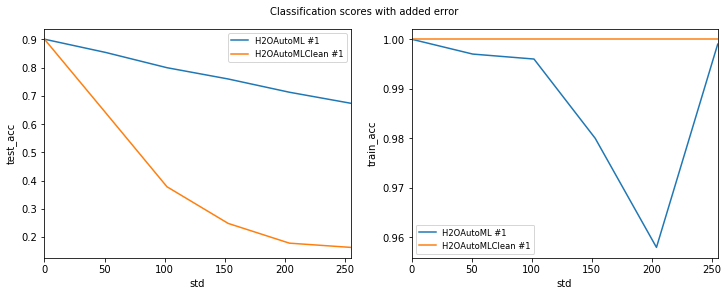

In [11]:
print_results_by_model(df,
    # ["train_labels", "test_labels"],
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    # err_param_name="max_angle",
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)